In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from learnMSA.msa_hmm import Configuration, Align, Visualize, Clustering, Initializers
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

2025-04-07 10:33:12.259173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-07 10:33:12.276151: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-07 10:33:12.281270: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1744014793.654103 2397811 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744014793.697434 2397811 cuda_executor.cc:1015] succ

## learnMSA tree demo

In this notebook, we will fit a number of HMM models to a dataset of unaligned sequences. 
We will then use the fitted models to align the sequences and compare the results.
Moreover, we will visualize the best (according to an objective criterion) model and alignment.

*This notebook is meant to be a demo for running learnMSA in Python code. Check the readme if you want to run learnMSA from the command line.* 

Change the variables in the following cell to fit your needs.

In [2]:
name = "2_200"
suffix = "_short"

# unaligned sequences
train_filename = f"../trees/alisim/{name}{suffix}.unaligned.fa"
# reference alignment of all sequences
ref_filename = f"../trees/alisim/{name}{suffix}.fa"
# tree used to generate the sequences
tree_filename = f"../trees/treegen/trees/{name}.nwk"

# number of distinct pHMMs
num_models = 2

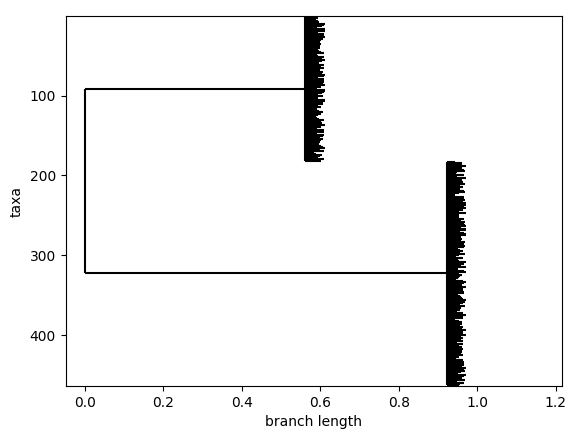

In [3]:
## Real tree used to generate the data
true_tree : Clustering.TreeHandler = Clustering.TreeHandler.read(tree_filename)
true_tree.draw(no_labels=True)

## Run learnMSA from Python (Training + Viterbi alignment)

In [4]:
# compute a clustering from the unaligned sequences
clustering : pd.DataFrame = Clustering.compute_clustering(train_filename, cluster_seq_id=0.3, linear=False)
tree_handler = Clustering.cluster_tree(clustering, branch_length=0.01)

# fig = plt.figure(figsize=(10, 50), dpi=100)
# axes = fig.add_subplot(1, 1, 1)
# print("Number of clusters:", tree_handler.num_anc-1)
# tree_handler.draw(no_labels=True, axes=axes)

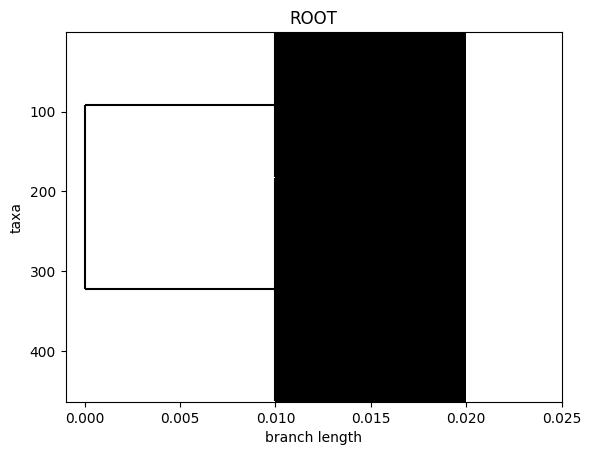

In [5]:
tree_handler.draw(no_labels=True)

Falsely clustered sequences can lead to poor alignments. We'll have to account for that.

In [6]:
# compute cluster precision
true_cluster_indices = true_tree.get_parent_indices_by_height(0)
cluster_indices = tree_handler.get_parent_indices_by_height(0)

true_positives = 0
positives = 0   

leaf_names = tree_handler.node_names[:tree_handler.num_leaves]
for i,u_name in enumerate(leaf_names):
    for v_name in leaf_names[i+1:]:
        u = tree_handler.nodes[u_name]
        v = tree_handler.nodes[v_name]
        tu = true_tree.nodes[u_name]
        tv = true_tree.nodes[v_name]
        if u.parent == v.parent:
            if tu.parent == tv.parent:
                true_positives += 1
            positives += 1

print("Cluster precision:", true_positives/positives)
print("True number of clusters: ", true_tree.num_anc-1)
print("Predicted number of clusters: ", tree_handler.num_anc-1)

Cluster precision: 1.0
True number of clusters:  2
Predicted number of clusters:  2


In [7]:
def encoder_weight_extractor(encoder_model : tf.keras.Model):
   K = -3.0 # default value if no kernel is found
   num_models = 1
   for layer in encoder_model.layers:
      if layer.name.startswith("anc_probs_layer"):
         K = layer.time_kernel.numpy()
         num_models = layer.num_models
   return [Initializers.ConstantInitializer(K)] + Initializers.make_LG_init(num_models)

In [ ]:
out_filename = "test/data/interactive.alignment.fasta"
with SequenceDataset(train_filename, fmt="fasta") as data:
    config = Configuration.make_default(num_models, 
                                        tree_handler=tree_handler,
                                        tree_loss_weight=1.0)
    config["epochs"] = [10, 5, 10]

    # making these smaller than 50%, the default, is required to account for
    # insertions in smaller clusters or deletions in larger clusters
    # config["surgery_ins"] = 0.2
    # config["surgery_del"] = 0.2

    config["crop_long_seqs"] = int(np.ceil(2 * np.mean(data.seq_lens))) #comment out to disable cropping
    config["encoder_weight_extractor"] = encoder_weight_extractor
    alignment_model = Align.run_learnMSA(data,
                                        out_filename,
                                        config, 
                                        verbose=True,
                                        align_insertions=True)

Training of 2 models on file 2_200_short.unaligned.fa
Configuration: 
{
num_models : 2
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alp

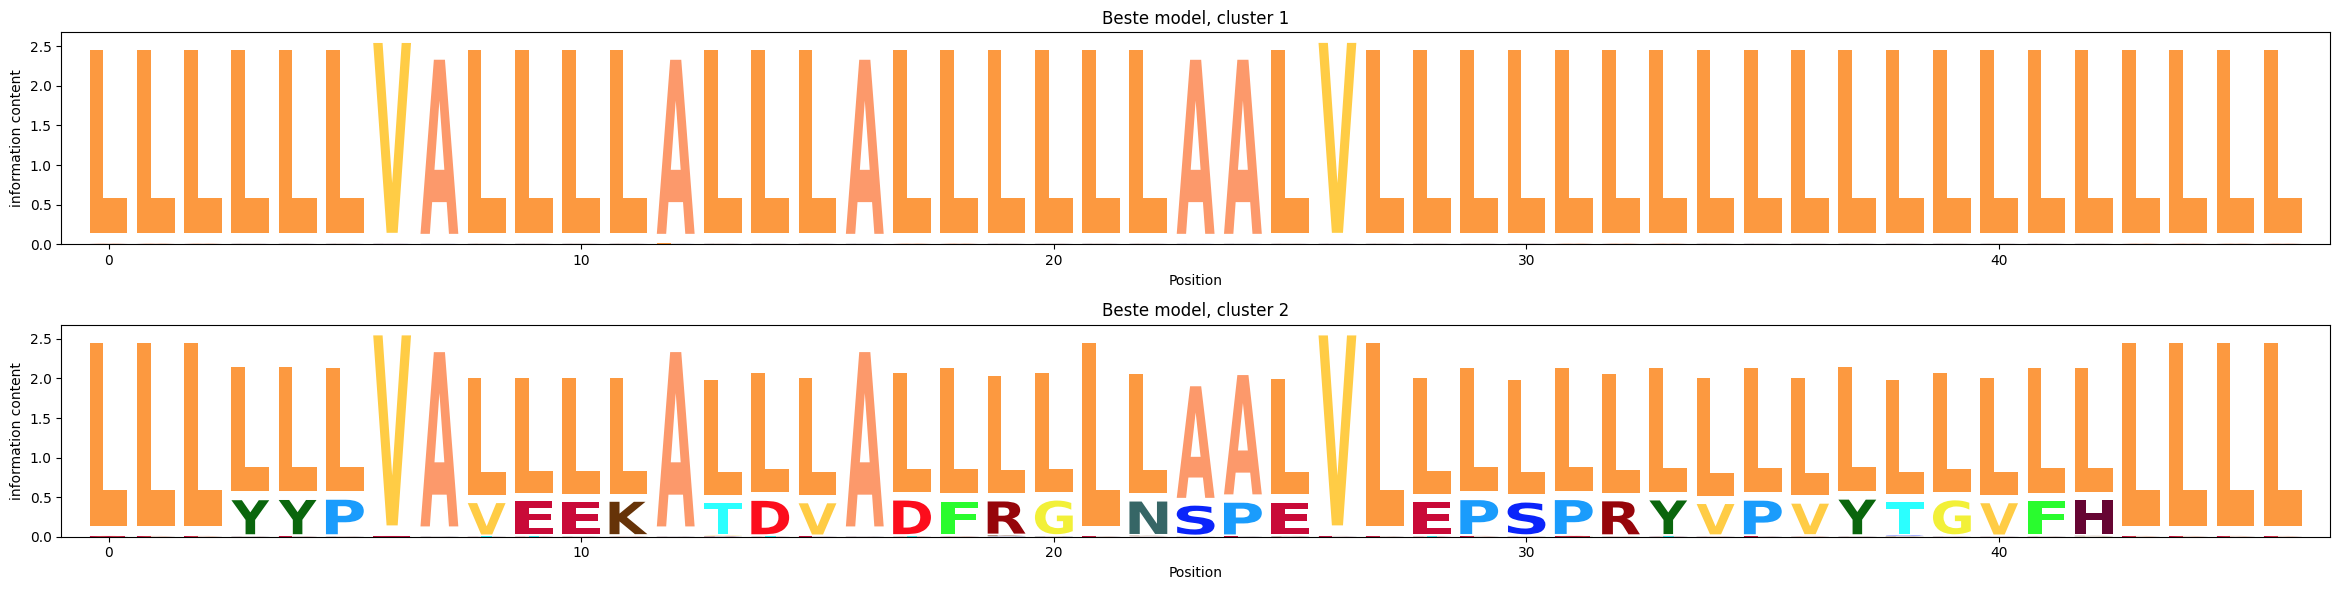

In [ ]:
num_clust = tree_handler.num_anc-1
fig, axes = plt.subplots(num_clust, 1, figsize=(10, 5))
for i in range(num_clust):
    ax = axes[i]
    ax.set_title(f"Beste model, cluster {i+1}")
    ax.set_xlabel("Position")
    ax.set_ylabel("Information content")
    Visualize.plot_logo(alignment_model, alignment_model.best_model, ax, cluster_index=i)
plt.tight_layout()

In [10]:
tf.math.softplus(alignment_model.model.layers[-5].cell.emitter[0].branch_lengths_kernel.numpy())

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.01231737, 0.01068554],
       [0.01231825, 0.01067617]], dtype=float32)>

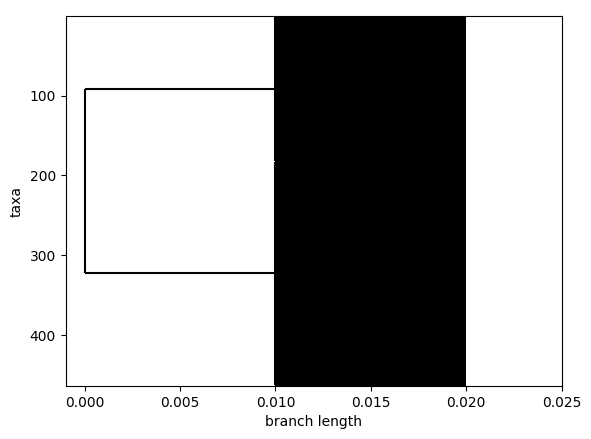

In [11]:
alignment_model.model.layers[-5].cell.emitter[0].tree_handler.draw(no_labels=True)

In [12]:
# currently not working
# Visualize.print_and_plot(alignment_model, alignment_model.best_model)

In [2]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in test/data/interactive.alignment.fasta -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.fasta

HERE: leaf0
HERE: leaf1
HERE: leaf2
HERE: leaf3
HERE: leaf4
HERE: leaf5
HERE: leaf6
HERE: leaf7
HERE: leaf8
HERE: leaf9
HERE: leaf10
HERE: leaf11
HERE: leaf12
HERE: leaf13
HERE: leaf14
HERE: leaf15
HERE: leaf16
HERE: leaf17
HERE: leaf18
HERE: leaf19
HERE: leaf20
HERE: leaf21
HERE: leaf22
HERE: leaf23
HERE: leaf24
HERE: leaf25
HERE: leaf26
HERE: leaf27
HERE: leaf28
HERE: leaf29
HERE: leaf30
HERE: leaf31
HERE: leaf32
HERE: leaf33
HERE: leaf34
HERE: leaf35
HERE: leaf36
HERE: leaf37
HERE: leaf38
HERE: leaf39
HERE: leaf40
HERE: leaf41
HERE: leaf42
HERE: leaf43
HERE: leaf44
HERE: leaf45
HERE: leaf46
HERE: leaf47
HERE: leaf48
HERE: leaf49
HERE: leaf50
HERE: leaf51
HERE: leaf52
HERE: leaf53
HERE: leaf54
HERE: leaf55
HERE: leaf56
HERE: leaf57
HERE: leaf58
HERE: leaf59
HERE: leaf60
HERE: leaf61
HERE: leaf62
HERE: leaf63
HERE: leaf64
HERE: leaf65
HERE: leaf66
HERE: leaf67
HERE: leaf68
HERE: leaf69
HERE: leaf70
HERE: leaf71
HERE: leaf72
HERE: leaf73
HERE: leaf74
HERE: leaf75
HERE: leaf76
HERE: lea

In [3]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.fasta -compare_mode sp

*****************************************************
seq1       seq2          Sim   [ALL]           Tot  
2_200_short   463        70.6    69.2 [100.0]   [7520738]


In [ ]:
# without tree emitter
out_filename = "test/data/interactive.alignment.notree.fasta"
config = Configuration.make_default(num_models)
with SequenceDataset(train_filename, fmt="fasta") as data:
    config["crop_long_seqs"] = int(np.ceil(2 * np.mean(data.seq_lens))) #comment out to disable cropping
    alignment_model = Align.run_learnMSA(data,
                                        out_filename,
                                        config, 
                                        sequence_weights=Clustering.compute_sequence_weights(train_filename, "tmp", config["cluster_seq_id"]),
                                        verbose=True,
                                        align_insertions=True)

Training of 2 models on file 2_200_short.unaligned.fa
Configuration: 
{
num_models : 2
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alp

Exception ignored in: <function AtomicFunction.__del__ at 0x7aa4a86f2a20>
Traceback (most recent call last):
  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py", line 286, in __del__
    def __del__(self):
  
KeyboardInterrupt: 


Fitting models of lengths [47, 46] on 463 sequences.
Batch size= 232 Learning rate= 0.1
Using sequence weights  [0.01333333 0.01333333 0.5        0.25       0.01333333 1.
 0.01333333 0.01333333 1.         1.         1.         0.5
 0.01333333 0.01333333 0.5        0.01333333 1.         0.5
 1.         0.01333333 0.01333333 1.         0.01333333 1.
 0.33333334 0.01333333 1.         0.01333333 0.5        0.01333333
 0.5        0.5        1.         0.01333333 0.01333333 0.01333333
 1.         1.         0.01333333 1.         0.01333333 1.
 1.         0.5        1.         1.         1.         0.01333333
 1.         0.33333334 1.         1.         0.01333333 1.
 1.         0.01333333 0.5        0.01333333 0.5        1.
 1.         1.         1.         0.5        0.25       1.
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 1.
 0.01333333 0.5        1.         0.01333333 0.01333333 1.
 1.         0.01333333 0.01333333 0.01333333 1.         0.33333334
 0.01333333 1.         0.013

In [ ]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in test/data/interactive.alignment.notree.fasta -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.notree.fasta

HERE: leaf0
HERE: leaf1
HERE: leaf2
HERE: leaf3
HERE: leaf4
HERE: leaf5
HERE: leaf6
HERE: leaf7
HERE: leaf8
HERE: leaf9
HERE: leaf10
HERE: leaf11
HERE: leaf12
HERE: leaf13
HERE: leaf14
HERE: leaf15
HERE: leaf16
HERE: leaf17
HERE: leaf18
HERE: leaf19
HERE: leaf20
HERE: leaf21
HERE: leaf22
HERE: leaf23
HERE: leaf24
HERE: leaf25
HERE: leaf26
HERE: leaf27
HERE: leaf28
HERE: leaf29
HERE: leaf30
HERE: leaf31
HERE: leaf32
HERE: leaf33
HERE: leaf34
HERE: leaf35
HERE: leaf36
HERE: leaf37
HERE: leaf38
HERE: leaf39
HERE: leaf40
HERE: leaf41
HERE: leaf42
HERE: leaf43
HERE: leaf44
HERE: leaf45
HERE: leaf46
HERE: leaf47
HERE: leaf48
HERE: leaf49
HERE: leaf50
HERE: leaf51
HERE: leaf52
HERE: leaf53
HERE: leaf54
HERE: leaf55
HERE: leaf56
HERE: leaf57
HERE: leaf58
HERE: leaf59
HERE: leaf60
HERE: leaf61
HERE: leaf62
HERE: leaf63
HERE: leaf64
HERE: leaf65
HERE: leaf66
HERE: leaf67
HERE: leaf68
HERE: leaf69
HERE: leaf70
HERE: leaf71
HERE: leaf72
HERE: leaf73
HERE: leaf74
HERE: leaf75
HERE: leaf76
HERE: lea

In [ ]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.notree.fasta -compare_mode sp

*****************************************************
seq1       seq2          Sim   [ALL]           Tot  
2_200_short   463        70.6    67.7 [100.0]   [7520738]
